# Use Machine Learning to Predict U.S. Opioid Prescribers with Scikit Learn


This Code Pattern will focus on and guide you through how to use scikit learn and python to predict opioid prescribers based off of a [2014 kaggle dataset](https://www.kaggle.com/apryor6/us-opiate-prescriptions/data).

In this notebook, we explore the dataset `opioids.csv`, `overdoses.csv`, `prescriber-info.csv` and apply:
- demographic data visualization
- machine learning trainings and model comparisons


<a id="section0"></a>
### Prerequisites

Before you run this notebook complete the following steps:
- Import required packages

#### Import required packages

Import and configure the required packages, including StringIO, requests, json, pandas, numpy.
This Code Pattern will focus on and guide you through how to use scikit learn and python  to predict opioid prescribers based off of a [2014 kaggle dataset](https://www.kaggle.com/apryor6/us-opiate-prescriptions/data).

In this notebook, we explore the dataset `opioids.csv`, `overdoses.csv`, `prescriber-info.csv` and apply:
- demographic data visualization
- machine learning trainings and model comparisons

In [183]:
#import packages
from io import StringIO
import requests
import json
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [184]:
# define path
path = '/root/notebook/Data science with python/predict-opioid-prescribers/data/'

In [185]:
path_opioids = path + 'opioids.csv'
# Using pandas to read the data 
df_data_1 = pd.read_csv(path_opioids,sep=',')
# Display the first five rows
df_data_1.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


The opioids.csv dataset has two columns, `Drug Name` and `Generic Name`. Each row represents one medicine with its drug name and generic name.

In [186]:
path_overdoses = path + 'overdoses.csv'
# Using pandas to read the data 
df_data_2 = pd.read_csv(path_overdoses)
# Display the first five rows
df_data_2.head()

,State,Population,Deaths,Abbrev
0,Alabama,"4,833,722",723,AL
1,Alaska,"735,132",124,AK
2,Arizona,"6,626,624","1,211",AZ
3,Arkansas,"2,959,373",356,AR
4,California,"38,332,521","4,521",CA


The overdoses.csv dateset has four columns, including `State`, `Population`, `Deaths`, and `Abbrev`. Each row represents a state and its populations, number of deaths and state abbreviation names.

In [187]:
path_overdoses = path + 'prescriber-info.csv'
# Using pandas to read the data 
df_data_3 = pd.read_csv(path_overdoses)
# Display the first five rows
df_data_3.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


The prescriber-info.csv displays number of drugs prescribed by 25000 medical professionals in the United States in 2014. The number of drug includes both opiate and non-opiate drugs. For each row, it represents a medical professional with their NPI number, gender, state, credentials, and speciality. In the paper *Opiate/Opioid prescription analysis using machine learning*, **they classify a doctor as opiate prescriber if he/she prescribe opiate drugs more than 10 times in total.**

## Exploration and Initial Preprocessing

Let's start out by removing the ',' from our numbers in the Deaths and Population columns so that we can use the cells as integers

In [188]:
df_data_2['Deaths'] = df_data_2['Deaths'].str.replace(',', '')
df_data_2['Deaths'] = df_data_2['Deaths'].astype(int)

In [189]:
df_data_2['Population'] = df_data_2['Population'].str.replace(',', '')
df_data_2['Population'] = df_data_2['Population'].astype(int)

Add an additional column where we see the deaths per capita per each state.

In [190]:
df_data_2['Deaths/Population'] = (df_data_2['Deaths']/df_data_2['Population'])

In [191]:
df_data_2.head()

,State,Population,Deaths,Abbrev,Deaths/Population
0,Alabama,4833722,723,AL,0.000150
1,Alaska,735132,124,AK,0.000169
2,Arizona,6626624,1211,AZ,0.000183
3,Arkansas,2959373,356,AR,0.000120
4,California,38332521,4521,CA,0.000118


In [192]:
df_data_2['Deaths/Population'].dtype

dtype('float64')

Import pixiedust. Use pixiedust to visualize our initial exploration.

Curious about how many opioid deaths in each state? Let's plot a graph.

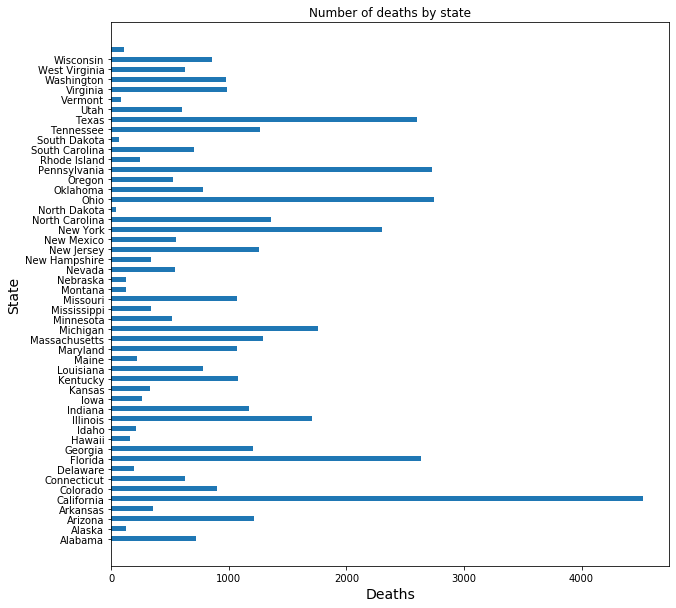

In [193]:
names = df_data_2['State'].values.tolist()
values = df_data_2['Deaths']
plt.figure(figsize=(10,10)) 
# 绘图 x= 起始位置， bottom= 水平条的底部(左侧), y轴， height 水平条的宽度， width 水平条的长度
plt.bar(x=0, bottom=names, height=0.5, width=values, orientation="horizontal")
plt.title('Number of deaths by state') 
plt.yticks(np.arange(49), names)           
plt.ylabel('State',fontsize=14) 
plt.xlabel('Deaths',fontsize=14) 
plt.show()

It definitely looks like California has significantly more deaths than any other states. 

Let's remember, however, California is a huge state with a matching population. Even thtough the total number of deaths is huge, it doesn't imply that people in California have a higher death rate. Because of this we need to take a look at the values of deaths per capita.

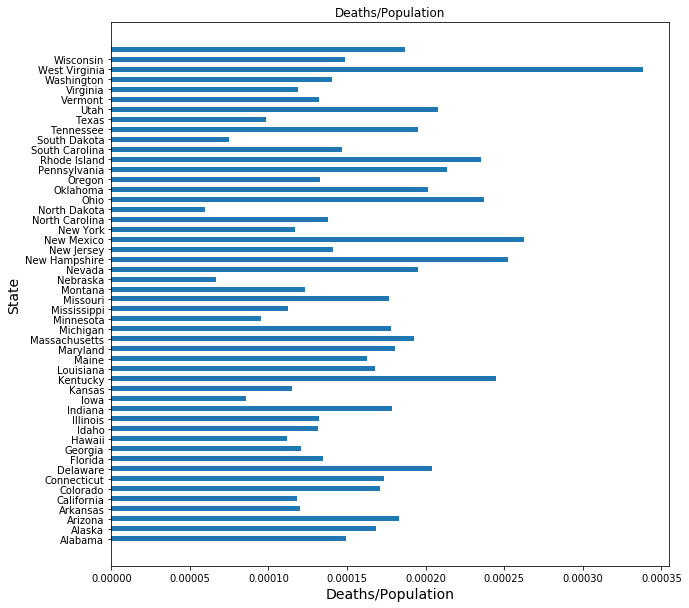

In [194]:
#What about deaths (% of population) by U.S. State?
names = df_data_2['State'].values.tolist()
values = df_data_2['Deaths/Population']
plt.figure(figsize=(10,10)) 
# 绘图 x= 起始位置， bottom= 水平条的底部(左侧), y轴， height 水平条的宽度， width 水平条的长度
plt.bar(x=0, bottom=names, height=0.5, width=values, orientation="horizontal")
plt.title('Deaths/Population') 
plt.yticks(np.arange(49), names)           
plt.ylabel('State',fontsize=14) 
plt.xlabel('Deaths/Population',fontsize=14) 
plt.show()

We can see that West Virginia, New Mexico, New Hampshire, Ohio, Kentucky and Delaware stand out. 

Let's check this out with a map. (I used google maps. To do this, create an API and enable JavaScript and GeoCoding. Then use your API key under 'Options'.)

### Let's move onto exploring our other dataset.

We seem to have a great deal of prescriptions as well as physicians' gender, state, speciality, whether they are an opioid prescriber or not and unique ID.

In [195]:
df_data_3.count()

NPI                  25000
Gender               25000
State                25000
Credentials          24237
Specialty            25000
                     ...  
XARELTO              25000
ZETIA                25000
ZIPRASIDONE.HCL      25000
ZOLPIDEM.TARTRATE    25000
Opioid.Prescriber    25000
Length: 256, dtype: int64

This table output reflects that there are 25000 unique medical professionals in the United States in year 2014.

### Data Cleaning

Why are there more than 50 states?

In [196]:
# Let's take a look at the states.
df_data_3.State.unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'PR', 'CO', 'OH',
       'MA', 'CT', 'FL', 'MN', 'UT', 'IA', 'IL', 'MT', 'IN', 'VA', 'CA',
       'OR', 'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC',
       'NJ', 'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI',
       'WV', 'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD', 'AE', 'ZZ', 'GU',
       'AA', 'VI'], dtype=object)

In [197]:
# Compare to df_data_2.
df_data_2.Abbrev.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

Compare the state list, clean up states to make the dataset state list equal.

I checked the list of US state abbreviations and did not recognize PR, AE, ZZ, GU, AA or VI. After checking I learned that PR is Puerto Rico, GU is Guam and VI is Virgin Islands. Though I identified 3 of the 6 unknowns, I'll remove all of them as dataset 2 does not have data regarding PR, GU or VI.

In [198]:
df_data_3 = df_data_3[df_data_3.State != 'AE']
df_data_3 = df_data_3[df_data_3.State != 'ZZ']
df_data_3 = df_data_3[df_data_3.State != 'AA']
df_data_3 = df_data_3[df_data_3.State != 'PR']
df_data_3 = df_data_3[df_data_3.State != 'GU']
df_data_3 = df_data_3[df_data_3.State != 'VI']

In [199]:
# Make sure it worked!
df_data_3.State.unique()

array(['TX', 'AL', 'NY', 'AZ', 'NV', 'PA', 'NH', 'WI', 'CO', 'OH', 'MA',
       'CT', 'FL', 'MN', 'UT', 'IA', 'IL', 'MT', 'IN', 'VA', 'CA', 'OR',
       'NE', 'MI', 'NM', 'TN', 'KS', 'LA', 'MD', 'MO', 'AR', 'NC', 'NJ',
       'SC', 'WY', 'ME', 'OK', 'ND', 'KY', 'GA', 'DE', 'WA', 'RI', 'WV',
       'AK', 'ID', 'VT', 'HI', 'MS', 'DC', 'SD'], dtype=object)

In [200]:
# Check out how many credentials there are.
df_data_3.Credentials.unique()

array(['DDS', 'MD', 'M.D.', 'DO', 'RN, MSN, ANP-BC', 'O.D.', nan,
       'D.D.S.', 'ACNP', 'DPM', 'PAC', 'A.R.N.P.', 'MSN, APRN, BC',
       'D.O.', 'M.D,', 'APRN', 'PA-C', 'CNM', 'RN CNP', 'DDS MS',
       'DNP, APRN-BC, FNP', 'PHARM D.', 'CRNP', 'ARNP', 'D.D.S', 'DPM MD',
       'FNP', 'NP', 'DMD', 'PA', 'MPT', 'D.M.D.', 'APRN BC FNP',
       'DMD,FAGD', 'MD,MPH', 'BDS,  DDS', 'D.D.S., F.A.G.D.', 'DDS, MD',
       'PMH, CNP/CNS', 'P.A.', 'M.D', 'D.O., MPH & TM', 'M.D., PH.D.',
       'RPA-C', 'MD FACOG', 'F.N.P.', 'D.O', 'ANP', 'FNP-C', 'D.M.D',
       'D.P.M.', 'OD', 'O. D.', 'CNS', 'MS, APRN, FNP-C', 'MD MPH',
       'NP-C', 'PHARM D', 'M.D.,', 'MBBS', 'PHYSICIAN ASSISTANT',
       'M.D. FCCP', 'MD.', 'CNP', 'DPT', 'D.D.S, M.D.', 'APRN, BC',
       'P.A.-C', 'M.D.P.A.', 'F.N.P.-C', 'M. D.', 'CFNP', 'C.N.P', 'APN',
       'D.D.S., A.P.C.', 'NP-C, MSN', 'MD FACP', 'R.P.A.', 'N.P.',
       'APRN, CNS', 'D.D.S., M.D.', 'PMHNP', 'MD, PHD, ABFP', 'APNP',
       'DMD, MD, PLLC', 'M.D., P.

In [201]:
# Check out the specialties.
df_data_3.Specialty.unique()

array(['Dentist', 'General Surgery', 'General Practice',
       'Internal Medicine', 'Hematology/Oncology', 'Family Practice',
       'Nurse Practitioner', 'Optometry', 'Cardiology',
       'Obstetrics/Gynecology', 'Podiatry', 'Physician Assistant',
       'Diagnostic Radiology',
       'Student in an Organized Health Care Education/Training Program',
       'Neurology', 'Certified Nurse Midwife', 'Rheumatology',
       'Pharmacist', 'Urology', 'Cardiac Electrophysiology',
       'Dermatology', 'Emergency Medicine', 'Psychiatry & Neurology',
       'Infectious Disease', 'Psychiatry', 'Gastroenterology',
       'Ophthalmology', 'Thoracic Surgery',
       'Oral Surgery (dentists only)', 'Anesthesiology',
       'Orthopedic Surgery', 'Otolaryngology', 'Pulmonary Disease',
       'Neuropsychiatry', 'Physical Therapist', 'Pediatric Medicine',
       'Physical Medicine and Rehabilitation', 'Maxillofacial Surgery',
       'Certified Clinical Nurse Specialist', 'Preventive Medicine',
       'A

In [202]:
# How much of the dataset is male vs female?
df_data_3.groupby('Gender').size() / df_data_3.groupby('Gender').size().sum()

Gender
F    0.378166
M    0.621834
dtype: float64

In [203]:
# How many prescribers in our dataset prescribe opioid drugs vs do not?
df_data_3.groupby('Opioid.Prescriber').size() / df_data_3.groupby('Opioid.Prescriber').size().sum()

Opioid.Prescriber
0    0.41282
1    0.58718
dtype: float64

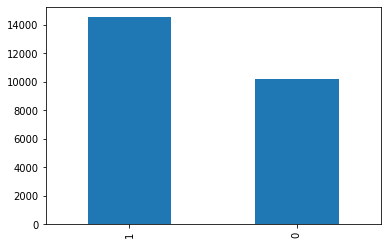

In [204]:
# Plot the opioid prescriber count vs non opioid prescriber count.
# The dataset has a slightly higher number of opioid prescribers.
pd.value_counts(df_data_3['Opioid.Prescriber']).plot.bar()

## Combination of Approaches: Kaggle and Indiana University

 - "Quick and Dirty" approach from Kaggle (https://www.kaggle.com/jiashenliu/quick-and-dirty-attempt-on-voting-classifier)
 - "Detecting Frequent Opioid Prescription" (https://inclass.kaggle.com/apryor6/detecting-frequent-opioid-prescription)
 - Indiana University: "Opiate prescription analysis using machine learning" (https://github.com/anirudhkm/opiate-prescription-analysis/blob/master/AML_report.pdf)

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [206]:
# Find the shape of our data frame so that we know how to set our classifiers up.
print(df_data_3.shape)

(24759, 256)


Mark opioid vs non opiod drugs in df_data_3 with use of df_data_1.

In [207]:
opioids = df_data_1 
name = opioids['Drug Name']
import re
new_name = name.apply(lambda x:re.sub("\ |-",".",str(x)))
columns = df_data_3.columns
Abandoned_variables = set(columns).intersection(set(new_name)) #Form the intersection of two Index objects.
Kept_variable = []
for each in columns:
    if each in Abandoned_variables:
        pass
    else:
        Kept_variable.append(each)

In [208]:
# Look at our new shape.
df = df_data_3[Kept_variable]
print(df.shape)

(24759, 245)


In [209]:
df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


Now let's remove the credentials column so that we can use the speciality column instead.

We will also remove the NPI column in order to trim our features down.

In [210]:
df = df.drop(df.columns[[0, 3]], axis = 1) 
df.head()

,Gender,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,M,TX,Dentist,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,F,AL,General Surgery,0,0,0,0,0,0,134,...,0,0,0,0,0,0,0,0,35,1
2,F,NY,General Practice,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,M,AZ,Internal Medicine,0,0,0,0,21,0,0,...,0,0,0,0,0,0,0,0,0,1
4,M,NV,Hematology/Oncology,0,0,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [211]:
# Let's now create our training and test data.
train,test = train_test_split(df,test_size = 0.2,random_state = 42)
print(train.shape)
print(test.shape)

(19807, 243)
(4952, 243)


In [212]:
# Now we convert our categorical columns.
Categorical_columns = ['Gender','State','Specialty']

for col in Categorical_columns:
    train[col] = pd.factorize(train[col], sort = True)[0]
    test[col] = pd.factorize(test[col],sort = True)[0]

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [213]:
# Set our features.
features = train.iloc[:,1:242] #make sure we only use the columns that we want as our features
features.head()

,State,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
11299,34,1,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17247,14,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14337,9,52,0,0,0,0,0,61,0,0,...,0,0,0,0,0,0,0,0,0,0
14452,35,85,0,0,17,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12366,9,66,0,0,0,0,0,0,0,0,...,0,0,0,19,0,0,0,0,0,0


## Creating our Classifiers to Predict Opioid Prescribers

In [214]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

Train our models. Let's use several classifiers so that we can check out which has the highest accuracy.

Added bagging classifier to check for overfitting (along with cross validation).

In [215]:
# With 'Gender' included.
features = train.iloc[:,0:242] 
# Make sure to remove Opioid.Prescriber (our target)!
target = train['Opioid.Prescriber']
Name = []
Accuracy = []
model1 = LogisticRegression(random_state = 22,C = 0.000000001,solver = 'liblinear',max_iter = 200)
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators = 200,random_state = 22)
model4 = GradientBoostingClassifier(n_estimators = 200)
model5 = KNeighborsClassifier()
model6 = DecisionTreeClassifier()
model7 = LinearDiscriminantAnalysis()
model8 = BaggingClassifier()
Ensembled_model = VotingClassifier(estimators = [('lr', model1), ('gn', model2), ('rf', model3),('gb',model4),('kn',model5),('dt',model6),('lda',model7), ('bc',model8)], voting = 'hard')
for model, label in zip([model1, model2, model3, model4,model5,model6,model7,model8,Ensembled_model], ['Logistic Regression','Naive Bayes','Random Forest', 'Gradient Boosting','KNN','Decision Tree','LDA', 'Bagging Classifier', 'Ensemble']):
    scores = cross_val_score(model, features, target, cv = 5, scoring = 'accuracy')
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.607866 of model Logistic Regression
Accuracy: 0.612056 of model Naive Bayes
Accuracy: 0.833039 of model Random Forest
Accuracy: 0.824557 of model Gradient Boosting
Accuracy: 0.778513 of model KNN
Accuracy: 0.780078 of model Decision Tree
Accuracy: 0.716665 of model LDA
Accuracy: 0.810320 of model Bagging Classifier
Accuracy: 0.833342 of model Ensemble


In [216]:
# Gender not included.
features=train.iloc[:,1:242] 
#Make sure to remove Opioid.Prescriber (our target)!
target = train['Opioid.Prescriber']
Name = []
Accuracy = []
model1 = LogisticRegression(random_state = 22,C = 0.000000001,solver = 'liblinear',max_iter = 200)
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators = 200,random_state = 22)
model4 = GradientBoostingClassifier(n_estimators = 200)
model5 = KNeighborsClassifier()
model6 = DecisionTreeClassifier()
model7 = LinearDiscriminantAnalysis()
model8 = BaggingClassifier()
Ensembled_model = VotingClassifier(estimators = [('lr', model1), ('gn', model2), ('rf', model3),('gb',model4),('kn',model5),('dt',model6),('lda',model7), ('bc',model8)], voting = 'hard')
for model, label in zip([model1, model2, model3, model4,model5,model6,model7,model8,Ensembled_model], ['Logistic Regression','Naive Bayes','Random Forest', 'Gradient Boosting','KNN','Decision Tree','LDA', 'Bagging Classifier', 'Ensemble']):
    scores = cross_val_score(model, features, target, cv = 5, scoring = 'accuracy')
    Accuracy.append(scores.mean())
    Name.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.607866 of model Logistic Regression
Accuracy: 0.612157 of model Naive Bayes
Accuracy: 0.835109 of model Random Forest
Accuracy: 0.824456 of model Gradient Boosting
Accuracy: 0.778058 of model KNN
Accuracy: 0.780936 of model Decision Tree
Accuracy: 0.712727 of model LDA
Accuracy: 0.813955 of model Bagging Classifier
Accuracy: 0.834806 of model Ensemble


Looks like our highest accuracy score is 83.5% with Random Forest, followed by 83.3% with the Ensemble.

Overall, it seems our models are less accurate when 'Gender' is included, with the exception of our Ensemble which gets a fairly high accuracy at 83.4% accuracy.

In [225]:
# Let's check out our best models from our run without 'Gender'.
Name_2 = []
Accuracy_2 = []
Ensembled_model_3 = VotingClassifier(estimators = [('rf', model3),('em',Ensembled_model)], voting = 'hard')
for model, label in zip([model3, model4,Ensembled_model_3, model8], ['Random Forest', 'Gradient Boosting', 'Ensemble', 'Bagging Classifier']):
    scores = cross_val_score(model, features, target, cv = 5, scoring = 'accuracy')
    Accuracy_2.append(scores.mean())
    Name_2.append(model.__class__.__name__)
    print("Accuracy: %f of model %s" % (scores.mean(),label))

Accuracy: 0.835109 of model Random Forest
Accuracy: 0.824456 of model Gradient Boosting
Accuracy: 0.837027 of model Ensemble
Accuracy: 0.813248 of model Bagging Classifier


In [226]:
from sklearn.metrics import accuracy_score
classifers = [model3,model4,model8]
out_sample_accuracy = []
Name_2 = []
for each in classifers:
    fit = each.fit(features,target)
    pred = fit.predict(test.iloc[:,1:242])
    accuracy = accuracy_score(test['Opioid.Prescriber'],pred)
    Name_2.append(each.__class__.__name__)
    out_sample_accuracy.append(accuracy)

### Evaluate

In [227]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
y_actu = test['Opioid.Prescriber']
confusion_matrix(y_actu, pred)

array([[1304,  747],
       [ 503, 2398]])

In [228]:
# Precision-Recall Curve
sklearn.metrics.precision_recall_curve(y_actu, pred, pos_label = None, sample_weight = None)

(array([0.58582391, 0.76248013, 1.        ]),
 array([1.        , 0.82661151, 0.        ]),
 array([0, 1]))

In [229]:
# Precision-Recall Score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_actu, pred)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.73


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.73')

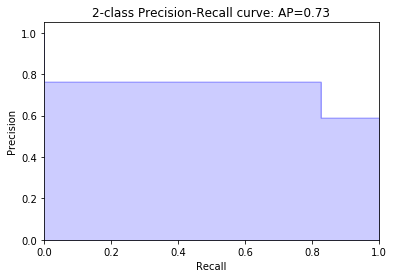

In [230]:
# Precision-Recall Curve Plot
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_actu, pred)

plt.step(recall, precision, color = 'b', alpha = 0.2,
         where = 'post')
plt.fill_between(recall, precision, step = 'post', alpha = 0.2,
                 color = 'b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

After running various classifiers, we find that Random Forest, Gradient Boosting and our Ensemble models had the best performance comparatively. This means that if we were to build a larger project, we could focus on these particular classifiers, building upon them to help predict opioid prescribers (given more years of data). 

The precision-recall curve can help us determine if we were successful enough. For the unfamiliar precision-recall scores represent a balance between high recall and high precision relating to a low false positive rate and a low false negative rate respectively. When evaluating, you have four outcomes: true positive, true negative, false positive and false negative. Depending on the project, you would aim for different balances, but ideally you want everything to be as accurate, or true, as possible. In the graph above, the y axis is the precision and the x axis is recall. If the graph went straight across the middle, that would be a random-like output. Below it would be poor performance and above it would be a more accurate and better quality performance. If it were 100 it would be a perfect classifier. Because the classifier above is at 0.84 we can feel confident that our precision was good. Now I challenge you to go improve it!